In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

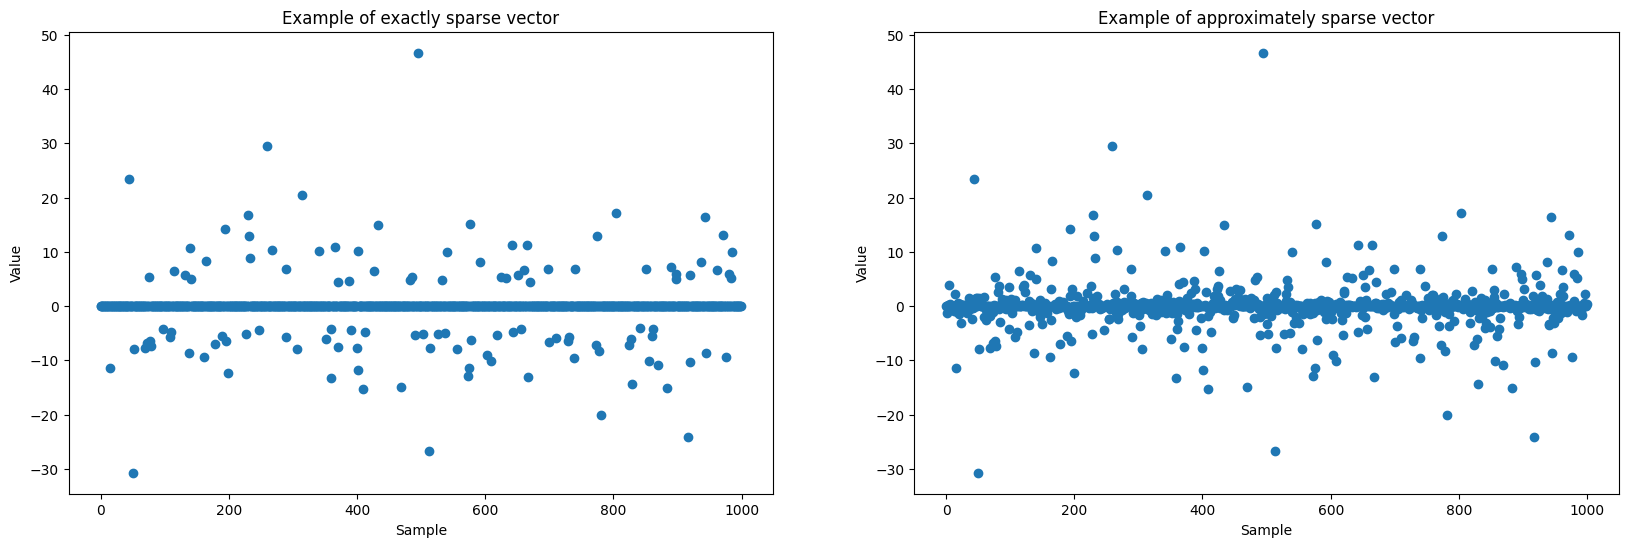

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

**Answer**

A signal $s \in \mathbb{R}^{n}$ is said to be $k$-sparse if only $k\ll t$ of its element are non-zeros: $\|s\|_0=k \ll t $ with the pseudo-norm $\|.\|_0$ being the cardinal of the support of $s$.

On the other hand, a signal $s \in \mathbb{R}^{n}$ is said to be approximately sparse when $\|s\|_0 \approx t $, but only $k\ll t$ of the signal samples have a large amplitude.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

**Answer**

We get the shape of a star. Indeed, most of the data is concentrated around (0,0), i.e. most of the samples don't have a large amplitude, according to the definition a approximately sparse signal.

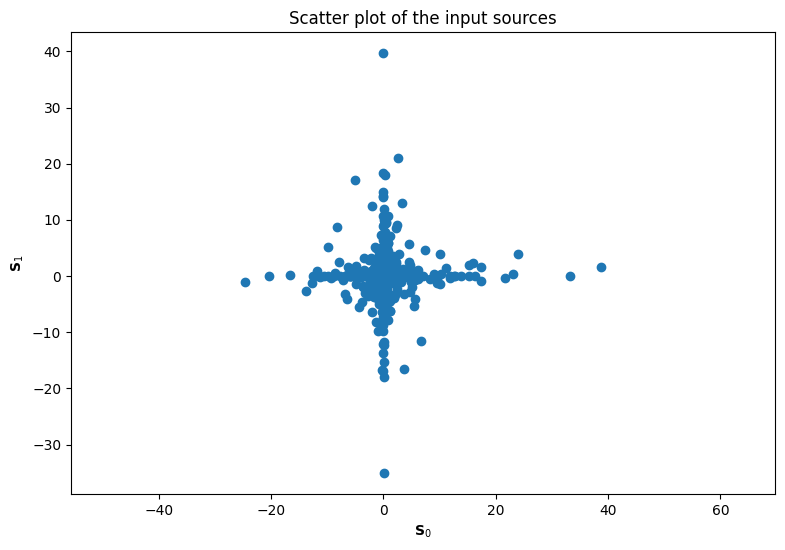

In [13]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 200 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
S = np.random.randn(n, t)**power # TO CHANGE

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [14]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ? 

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

**Answer**

We still recognize a star shaped 2D-signal, as the original 2D-sparse signal.

The directions of the lines correspond to the two principal directions of the signal after mixing (since for each randomly generated mixture matrix A, we get different directions).

The higher the power, the more sparse the 2D signal, thus the more robust is the mixture to the noise.

The noisier the signal, the less sparse the 2D signal is, thus the more the mixing will scramble the signal (the star-shape starts to disappear)

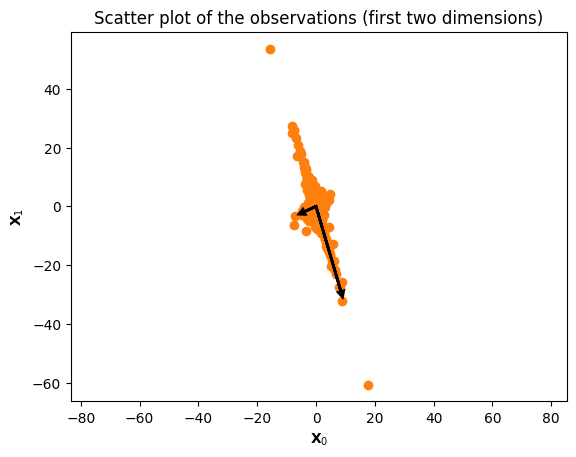

In [15]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

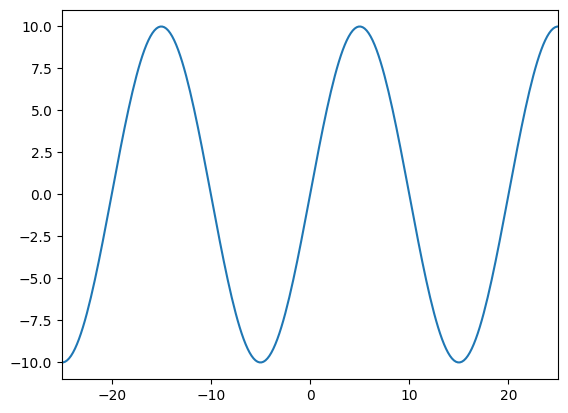

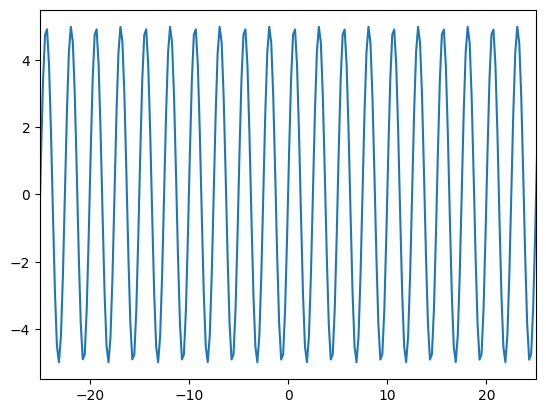

In [16]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

**Answer**

DCT changes a signal for time space to frequency space. Our sine signals are sparse in the frequency space, with a "spike" at their frequency.

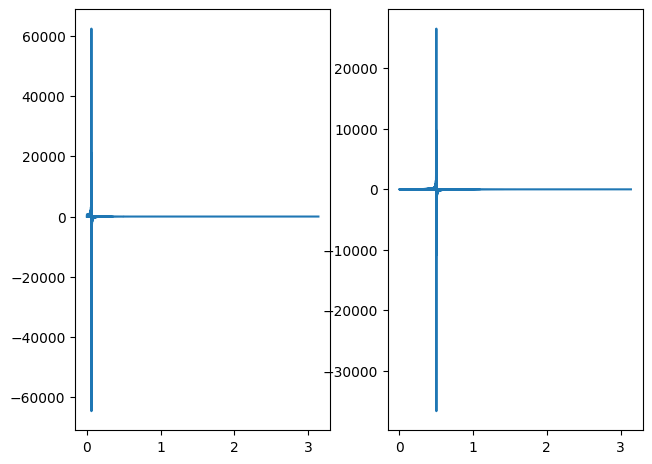

In [23]:
# Transformation into the DCT domain
Sf = sff.dct(S)

# DCT transform is in the frequency space, so we want x to be in [0, pi]

k = np.linspace(0, t-1, t)
x = np.pi/t * k

fig, ax =  plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(x, Sf[0, :])
ax[1].plot(x, Sf[1, :])
fig.show()


Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

**Answer**

X is a mixture of the two sine signals, which we can't decorrelate as such. Why using the DCT of X, we change to a sparse signal in the frequency space. The spikes we see correspond to the frequencies of the source signals. Using the DCT of a mixture of signals, we could reconstructesd the source signal by a multiplicative factor.

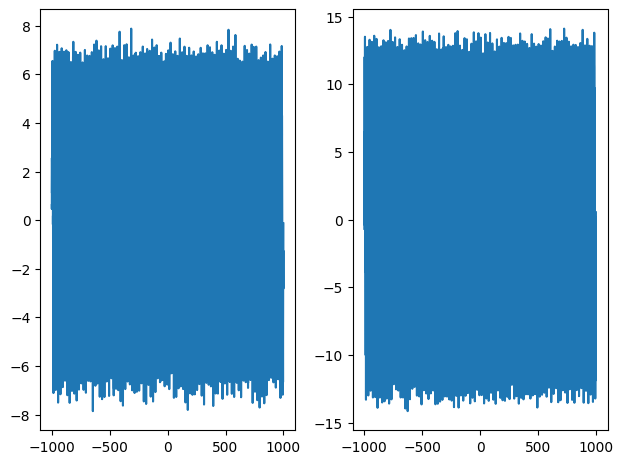

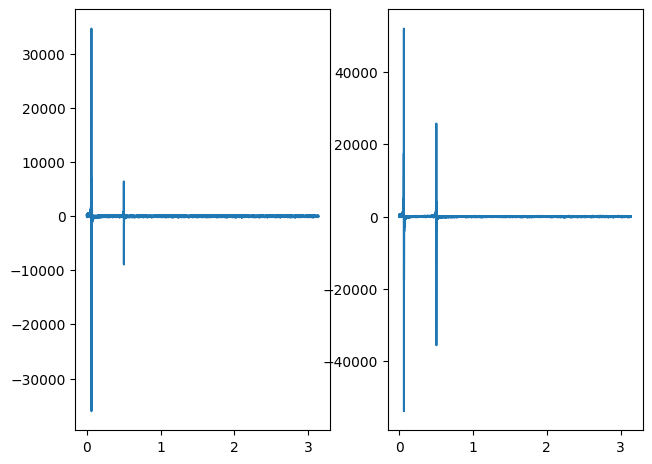

In [22]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values
X_DCT = sff.dct(X)

fig, ax =  plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(x_abs, X[0, :])
ax[1].plot(x_abs, X[1, :])
fig.show()

fig, ax =  plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(x, X_DCT[0, :])
ax[1].plot(x, X_DCT[1, :])
fig.show()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

**Answer**

We want to minimize $ ||X - AS||^2 + \lambda ||S||_1$ w.r.t. to $S$. The first term is the data-fidelity term (how close we are to the original data) while the second one makes the solution sparse (L1 norm penalizes vectors with a lot of non-zero components). This function is convex but non-differentiable because of L1-norm.


Compute the gradient along the S variable of the data-fidelity term.

**Answer**

$ \nabla_S ( ||X - AS||^2) = -A^T(X-AS) $

Recall what the proximal operator of the l1-norm is.

**Answer**
$$
\text{prox}_{\lambda\|.\|_1}(S)_i = \left\{
\begin{array}{lll}
    s_i - \lambda & \text{if } s_i \ge \lambda \\
    0 & \text{if } |s_i| \le 1 \\
    s_i + \lambda & \text{if } s_i \le -\lambda \\
\end{array}
\right.
$$

In [24]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
    S_est[S_est>thrd] -=  thrd
    S_est[S_est<-thrd] += thrd
    S_est[abs(S_est)<=thrd] = 0
    return S_est



Explain the main idea of the ISTA algorithm. Then, implement it.

**Answer**

The ISTA algorithm is an optimization algorithm using a combination of gradient descent and thresholding.

In [25]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    
    k=0
    gamma = 0.9/ np.linalg.norm(A.T@A)
    
    S_est = np.zeros((n, X.shape[1]))
    
    while k< nbIt :
        S_est = prox_l1(S_est + gamma * A.T @ (X-A@S_est), gamma*lamb)
        
        k += 1
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

**Answer**

If $\lambda$ is too big, the regularization term is too strong, and the result is almost everywhere zero (sparsity is too strong). If $\lambda$ is too little, then the result is too noisy and we can't determine the frequency of the source signals.

In [27]:
S_estf = ISTA(X_DCT,A = A,n=2,lamb=1000,nbIt = 1000)



Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

**Answer**

They appear as spikes corresponding to the frequencies of the source signals.

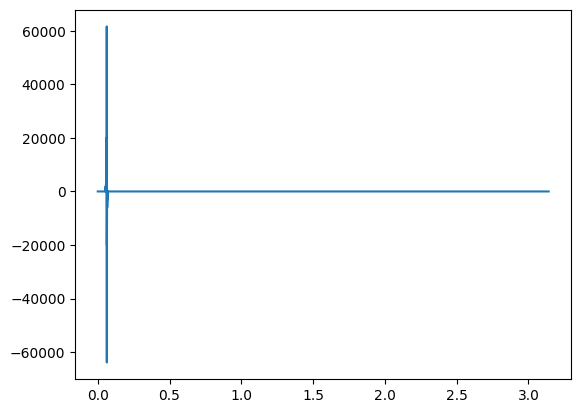

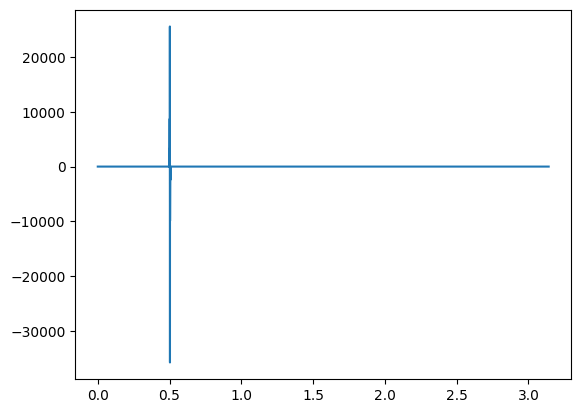

In [28]:
plt.plot(x,S_estf[0,:])
plt.show()
plt.plot(x,S_estf[1,:])
plt.show()

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

**Answer**

The reconstructed signals are finite, the signals aren't reconstructed correctly on the extremum of the domain. Yet they have the same amplitude and frequencies (edge effects aside) as the original signals.

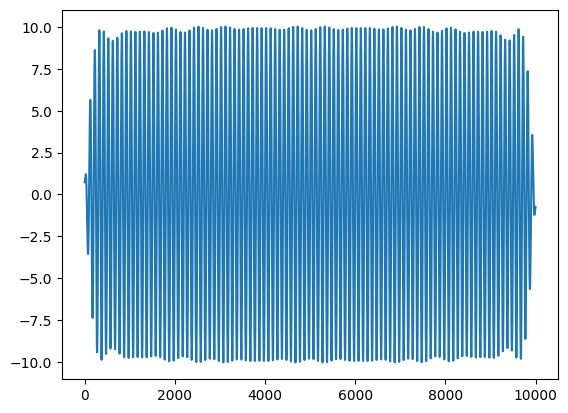

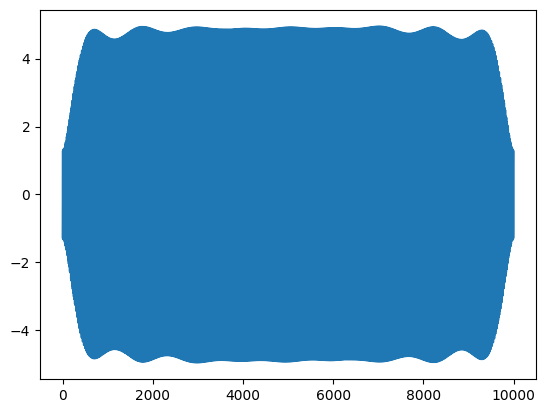

In [29]:
S_ori = sff.idct(S_estf)/20000


plt.plot(S_ori[0,:])
plt.show()
plt.plot(S_ori[1,:])
plt.show()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




Recall what the gradient of the data fidelity term over A is.

Compte the proximal operator of the oblique constraint. Implement it.

In [ ]:
#def prox_oblique(A):
#    # TO DO      
#    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [ ]:
#def PALM(X,n=2,lamb=0,nbIt = 100):
#    
#    # TO DO
#        
#    return A_est,S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

(-25.0, 25.0)

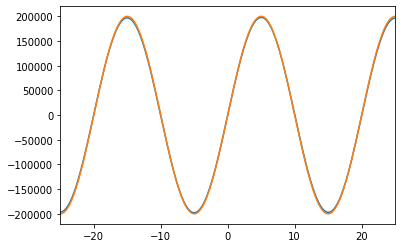

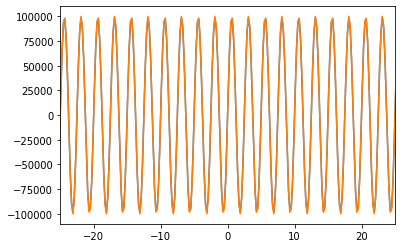